In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import dateutil
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Load data

column_names = ['ip', 'date', 'method', 'link', 'status', 'response_size', 'browser']
df = pd.read_csv('/home/py-chemist/Documents/access_logs/nginx/logs.csv', names=column_names)

In [5]:
# ip column is not shown

df.iloc[:, 1:].head()

,date,method,link,status,response_size,browser
0,date,method,link,status,response_size,browser
1,23/Apr/2017:06:53:17,GET,/mol_2_chemfig,200,2090,Mozilla
2,23/Apr/2017:06:53:17,GET,/apple-touch-icon-precomposed.png,404,209,Safari
3,23/Apr/2017:06:53:17,GET,/apple-touch-icon.png,404,209,Safari
4,23/Apr/2017:06:53:17,GET,/favicon.ico,404,209,Safari


In [12]:
# Getting basic info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209646 entries, 0 to 209645
Data columns (total 7 columns):
ip               209646 non-null object
date             209646 non-null object
method           209646 non-null object
link             209646 non-null object
status           209646 non-null object
response_size    209646 non-null object
browser          209646 non-null object
dtypes: object(7)
memory usage: 11.2+ MB


In [23]:
# Count response statuses

df.status.value_counts()

404       116279
200        80248
500         9256
304         2885
400          744
206           69
499           61
502           52
403           32
test           8
302            6
405            2
408            1
/              1
status         1
301            1
Name: status, dtype: int64

In [20]:
# I will use only 200 and 206 ("OK" status)

ok = df[(df.status == "200") | (df.status == "206")]

In [26]:
# % of "OK" status

ok.status.value_counts().sum()/df.status.value_counts().sum() * 100

38.31077149098957

In [28]:
# Number of unique ip addresses

ok.ip.unique().size

3350

In [30]:
# Get countries based on ip

unique_ip = ok.ip.unique().tolist()

countries = [requests.get('http://freegeoip.net/json/' + i).json()['country_name'] for i in unique_ip]

In [33]:
# some countries were not extracted from ip

print(countries[:10])

['Germany', 'Germany', '', '', '', 'Germany', 'Denmark', 'United States', 'Germany', 'Germany']


In [36]:
countries_df = pd.DataFrame({'ip': unique_ip, 'country': countries})

In [47]:
# Number of missing countries

countries_df[countries_df.country == '']['country'].value_counts()

    23
Name: country, dtype: int64

In [50]:
# Getting "bad" ip

bad_ip = countries_df[countries_df.country == '']['ip']

In [51]:
# exclude "bad" ip from ok dataframe

ok = ok[~ok['ip'].isin(bad_ip.values)]

In [53]:
# assign countries to the rest (non-unique) ip

d = dict(zip(unique_ip, countries))
d = {k:v for k,v in d.items() if v != ''}
ok['country'] = ok['ip'].apply(lambda x: d[x])

In [56]:
ok.iloc[:, 1:].head()

,date,method,link,status,response_size,browser,country
1,23/Apr/2017:06:53:17,GET,/mol_2_chemfig,200,2090,Mozilla,Germany
8,23/Apr/2017:06:53:17,GET,/mol_2_chemfig,200,2090,Mozilla,Germany
15,23/Apr/2017:06:56:50,GET,/mol_2_chemfig,200,2090,Mozilla,Germany
16,23/Apr/2017:06:57:16,GET,/mol_2_chemfig/_get_smiles?chemical=dibencylid...,200,16,Mozilla,Germany
17,23/Apr/2017:06:57:43,GET,/mol_2_chemfig,200,2090,Mozilla,Germany


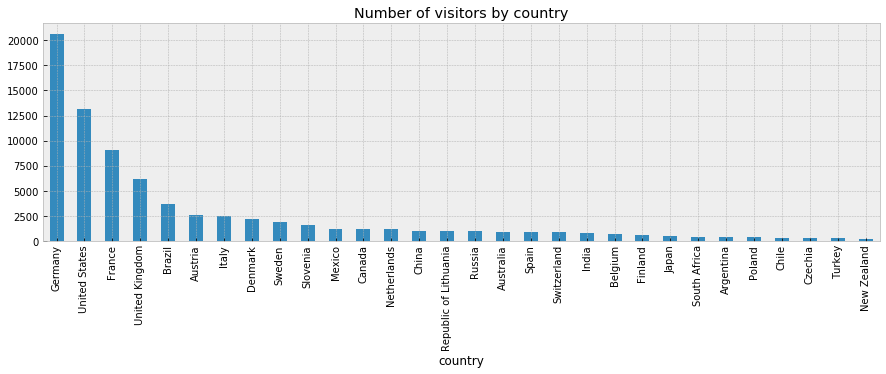

In [68]:
# Now we can estimate the most frequent visitors by country(top 30)

ok.groupby('country')['ip'].count().sort_values(ascending=False)[:30].plot(kind='bar',
                                                                           figsize=(15, 4),
                                                                          title='Number of visitors by country')

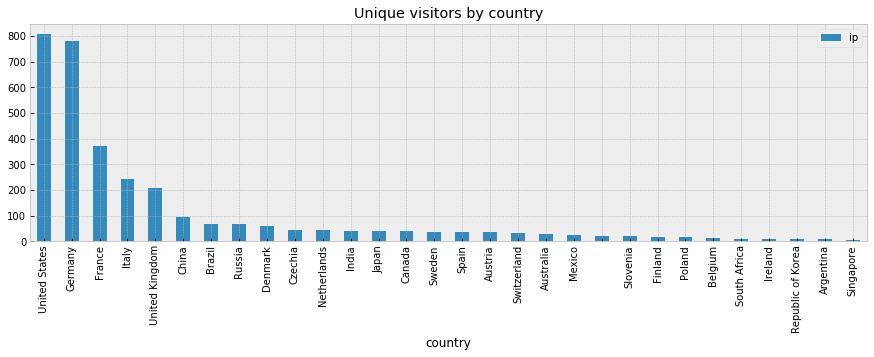

In [89]:
# Unique users by country
countries_df.groupby('country').count().sort_values(by='ip', ascending=False)[:30].plot(kind='bar',
                                                                                        figsize=(15, 4),
                                                                                       title='Unique visitors by country')

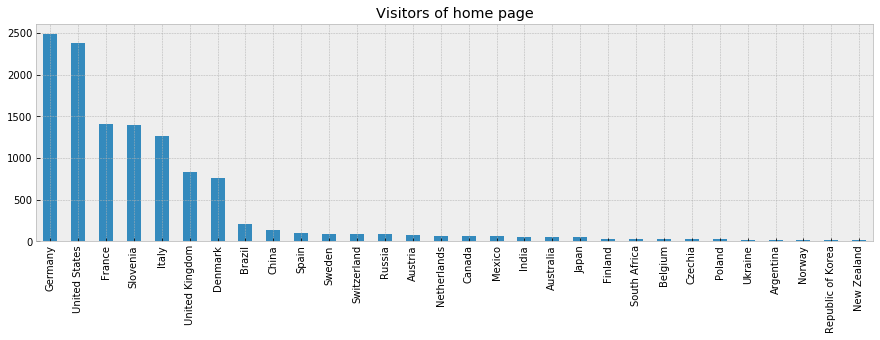

In [91]:
# Number of visitors of home page

home_page = ok[ok['link'] == '/mol_2_chemfig']
home_page.country.value_counts()[:30].sort_values(ascending=False).plot(kind='bar',
                                                                        figsize=(15, 4),
                                                                        title='Visitors of home page'
                                                                       )

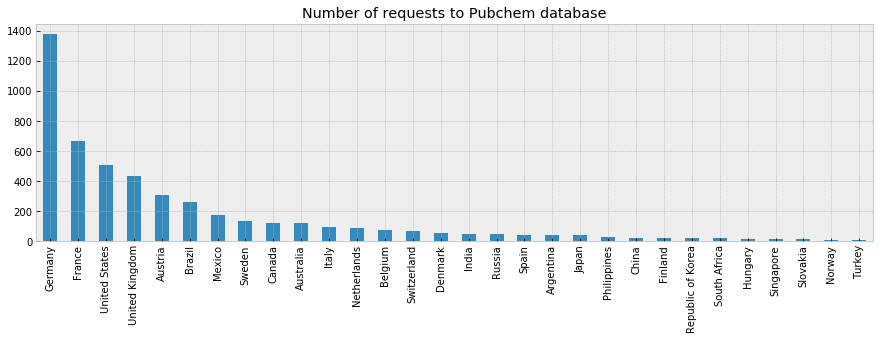

In [93]:
# Number of requests to Pubchem database to get smiles format

pubchem = ok[ok['link'].str.contains('/mol_2_chemfig/_get_smiles')]
pubchem['country'].value_counts()[:30].sort_values(ascending=False).plot(kind='bar',
                                                                       figsize=(15, 4),
                                                                        title="Number of requests to Pubchem database")

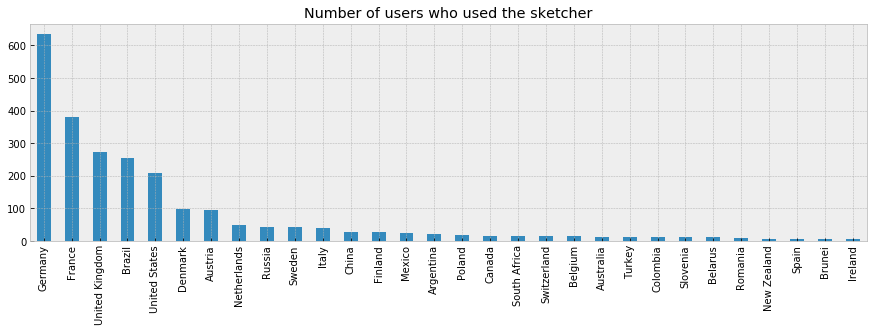

In [96]:
# Usage of the sketcher to generate MOL files

smiles_and_mols = ok[ok['link'].str.contains("/mol_2_chemfig/smiles_to_chemfig?")]
mols = smiles_and_mols[smiles_and_mols['link'].str.contains('Molecule')]
mols.country.value_counts()[:30].sort_values(ascending=False).plot(kind='bar',figsize=(15, 4),
                                                                  title="Number of users who used the sketcher")

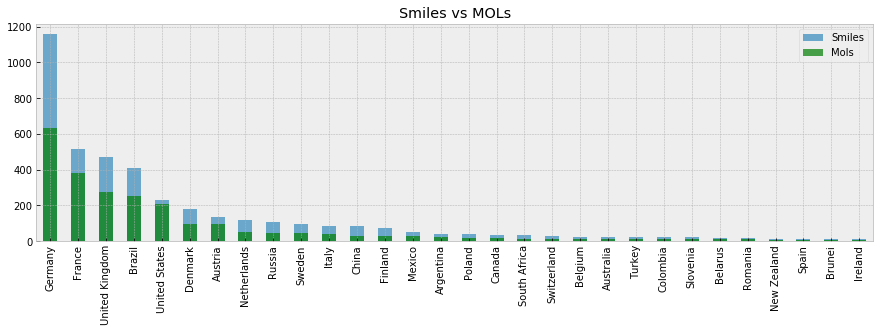

In [101]:
smiles = smiles_and_mols[~smiles_and_mols.index.isin(mols.index)]
fig, ax = plt.subplots(figsize=(15, 4))
smiles['country'].value_counts()[:30].sort_values(ascending=False).plot(kind='bar', ax=ax,
                                                                        alpha=0.7, label='Smiles')
mols['country'].value_counts()[:30].sort_values(ascending=False).plot(kind='bar', ax=ax, color="green",
                                                                      label='Mols',alpha=0.7)
ax.legend().set_visible(True)
plt.title("Smiles vs MOLs")

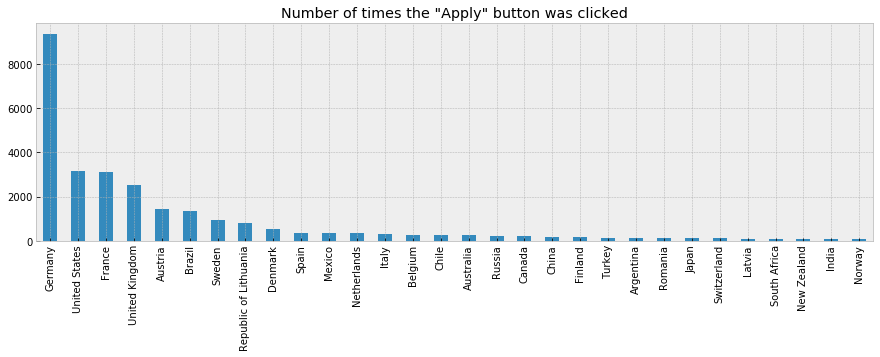

In [103]:
# Number of time the structure was modified

ok[ok.link.str.contains('/mol_2_chemfig/update?')]['country'].value_counts()[:30].plot(kind='bar',
                                                                                       figsize=(15, 4),
                                                                                      title='Number of times the "Apply" button was clicked')

In [106]:
ok['date'] = ok['date'].apply(lambda x: dateutil.parser.parse(x.replace(':', ' ', 1)))

In [108]:
ok['date'] = pd.to_datetime(ok['date'])

In [120]:
ok['date'] = pd.DatetimeIndex(ok.date.values)

In [122]:
ok['month'] = ok['date'].apply(lambda x: x.month)

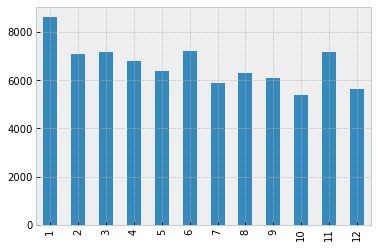

In [131]:
ok.month.value_counts().sort_index().plot(kind='bar')

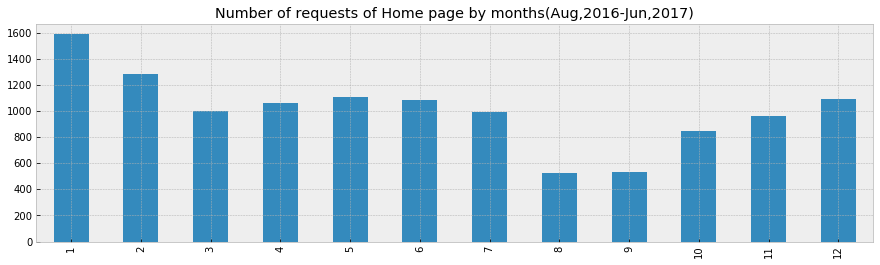

In [136]:
# Number of visitors of Home page by months

ok[ok['link'] == '/mol_2_chemfig'].month.value_counts().sort_index().plot(kind='bar',
                                                                         figsize=(15, 4),
                                                                         title="Number of requests of Home page by months(Aug,2016-Jun,2017)")

In [ ]:
# to be continued